<a href="https://colab.research.google.com/github/duckkk7/flowers/blob/main/flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Установка параметров
IMG_SIZE = 224       # Размер изображения для EfficientNetB0
BATCH_SIZE = 32      # Размер батча
NUM_CLASSES = 102    # Количество классов в Oxford Flowers 102

In [3]:
# Загрузка датасета Oxford Flowers 102
# Датасет делится на train, validation и test
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'oxford_flowers102',
    split=['train', 'validation', 'test'],
    with_info=True,
    as_supervised=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.NIBMSP_2.1.1/oxford_flowers102-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.NIBMSP_2.1.1/oxford_flowers102-test.tfrecord*…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.NIBMSP_2.1.1/oxford_flowers102-validation.tfr…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


In [4]:
# Функция предварительной обработки изображений:
def preprocess(image, label):
    # Изменение размера изображения
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    # Применение препроцессинга, соответствующего EfficientNetB0
    image = tf.keras.applications.efficientnet.preprocess_input(image)
    return image, label

In [5]:
# Применяем функцию preprocessing и группируем данные в батчи
ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.shuffle(1024).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

ds_val = ds_val.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [6]:
# Построение модели на основе предобученной EfficientNetB0
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
base_model.trainable = False  # замораживаем базовую модель для ускорения обучения

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
# Добавляем классификационную голову
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
# Компиляция модели
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 102)                 │         130,662 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,180,233 (15.95 MB)

 Trainable params: 130,662 (510.40 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [9]:
# Обучение модели
EPOCHS = 15
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=EPOCHS
)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 189s 5s/step - accuracy: 0.0568 - loss: 4.5563 - val_accuracy: 0.4098 - val_loss: 3.5928
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 158s 5s/step - accuracy: 0.4559 - loss: 3.2655 - val_accuracy: 0.6716 - val_loss: 2.6882
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 147s 5s/step - accuracy: 0.7488 - loss: 2.3071 - val_accuracy: 0.7627 - val_loss: 2.0888
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 190s 4s/step - accuracy: 0.8554 - loss: 1.6532 - val_accuracy: 0.8039 - val_loss: 1.7010
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 154s 5s/step - accuracy: 0.9213 - loss: 1.2352 - val_accuracy: 0.8245 - val_loss: 1.4406
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 183s 4s/step - accuracy: 0.9341 - loss: 0.9919 - val_accuracy: 0.8324 - val_loss: 1.2627
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 129s 4s/step - accuracy: 0.9525 - loss: 0.7816 - val_accuracy: 0.8373 - val_loss: 1.1352
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 135s 4s/step - accuracy: 0.9568 - loss: 0.6561 - val_accuracy: 0.8520 - v

In [20]:
# Функция для предсказания класса на стороннем изображении по указанному пути
def predict_image(image_path):
    from tensorflow.keras.preprocessing import image as keras_image

    img_display = keras_image.load_img(image_path)

    # Загружаем и подготавливаем изображение
    img = keras_image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)

    # Получаем предсказание
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]

    class_names = ds_info.features['label'].names
    predicted_class_name = class_names[predicted_class]

    # Отображение изображения с предсказанием
    plt.figure(figsize=(8, 6))
    plt.imshow(img_display)  # Показываем оригинальное изображение
    plt.axis('off')
    plt.title(f"Предсказание: {predicted_class_name}\n(Индекс: {predicted_class})",
              fontsize=12, pad=20)
    plt.show()

    print(f"Предсказанный класс: {predicted_class_name}, (индекс {predicted_class})")
    return predicted_class

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


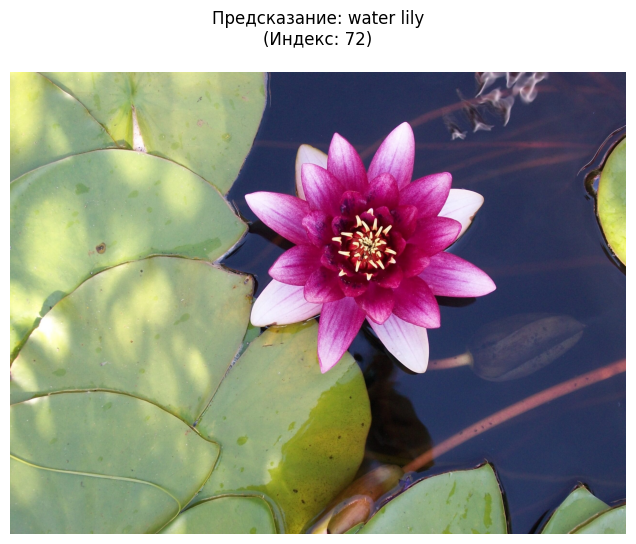

Предсказанный класс: water lily, (индекс 72)


np.int64(72)

In [21]:
predict_image("/content/drive/MyDrive/flowers/waterlily.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


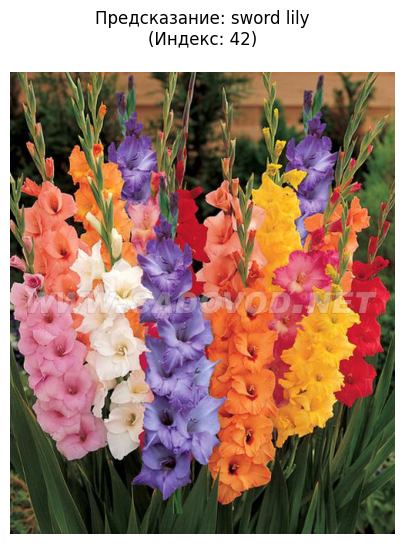

Предсказанный класс: sword lily, (индекс 42)


np.int64(42)

In [22]:
predict_image("/content/drive/MyDrive/flowers/swordlily(gladiolus).jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


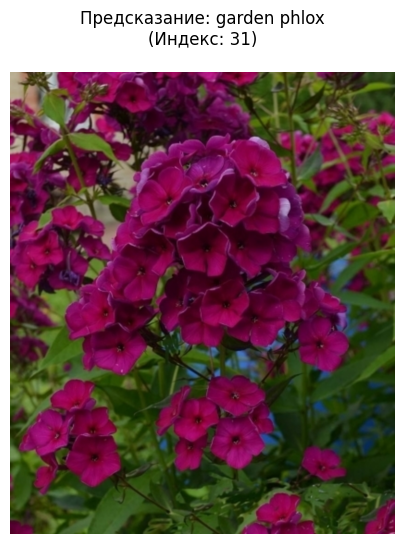

Предсказанный класс: garden phlox, (индекс 31)


np.int64(31)

In [24]:
predict_image("/content/drive/MyDrive/flowers/floksy.jpg")

In [11]:
# Функция для построения графиков точности и потерь
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # График точности
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Точность на обучении')
    plt.plot(history.history['val_accuracy'], label='Точность на валидации')
    plt.xlabel('Эпоха')
    plt.ylabel('Точность')
    plt.legend()
    plt.title('Точность обучения')

    # График потерь
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Потери на обучении')
    plt.plot(history.history['val_loss'], label='Потери на валидации')
    plt.xlabel('Эпоха')
    plt.ylabel('Потери')
    plt.legend()
    plt.title('Потери обучения')

    plt.show()

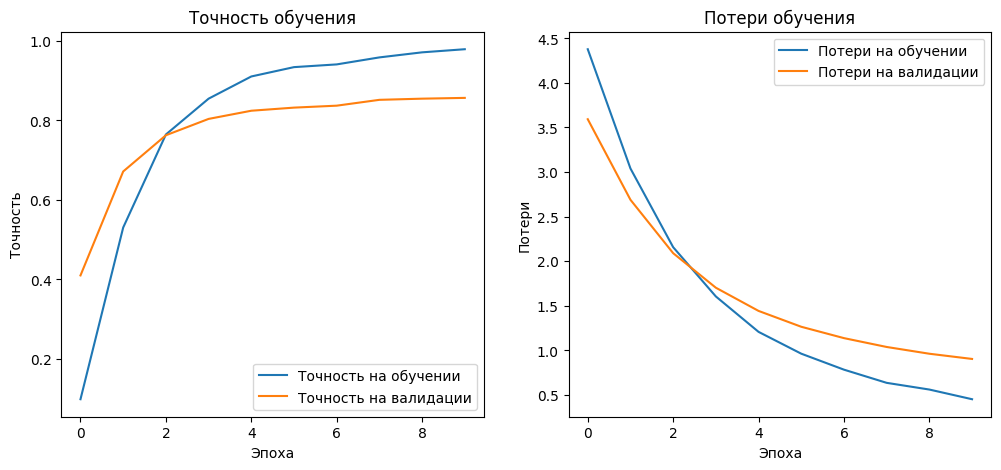

In [12]:
# Вызов функции для построения графиков
plot_training_history(history)